In [1]:
import pandas as pd
import yfinance as yf

In [3]:
# the 1h data only available within 2 years
sp500 = yf.download("^GSPC", start="2021-04-27", end="2023-04-26", interval="1h")
sp500 = sp500['Adj Close'] - sp500['Open']
#sp500.values

[*********************100%***********************]  1 of 1 completed


In [177]:
## Modeling
import keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.optimizers import Adam
import math
import numpy as np
import random
from collections import deque

# import section
from pandas import read_csv
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, GRU
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt



In [175]:
class Agent_LSTM:
    def __init__(self, state_size, hidden_unit, is_eval=False, model_name=""):
        self.state_size = state_size  # normalized previous days
        self.action_size = 3  # sit, buy, sell
        self.hidden_unit = hidden_unit
        self.memory = deque(maxlen=1000)
        self.inventory = []
        self.model_name = model_name
        self.is_eval = is_eval
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.model = load_model(model_name) if is_eval else self._model()
        self.loss_l = []
        self.val_loss_l = []

    def _model(self):
        # initiate model
        model = Sequential()
        model.add(LSTM(self.hidden_unit, input_shape=(self.state_size,1)))#self.state_size,1),))# activation=activation[0]))
        model.add(Dense(units=3))#self.action_size,))# activation=activation[1]))
        model.compile(optimizer = "RMSprop", loss = 'mae')
        return model

    def act(self, state):
        if not self.is_eval and random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        options = self.model.predict(np.array([state]), verbose=0)
        return np.argmax(options[0])

    def expReplay(self):

        state_l = []
        target_l = []
        for state, action, reward, next_state, done in self.memory:
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(np.array([next_state]), verbose=0)[0])
            target_f = self.model.predict(np.array(  [state]), verbose=0)
            target_f[0][action] = target

            state_l.append(state)
            target_l.append(target_f)

        train_history = self.model.fit(np.array([state]), target_f, epochs=10, verbose=0)

        self.loss_l.append(train_history.history['loss'])

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


In [173]:
def getState(data,time_step, window_size):
    window = data[time_step - window_size:time_step]
    return window.reshape(len(window),1).astype(np.float32)


In [14]:
from data_simulation import process_price_traces

start_price =  100
alpha = 1.0
time_steps = 100
num_traces = 500

process_traces = process_price_traces(
    start_price=start_price,
    alpha=alpha,
    time_steps=time_steps,
    num_traces=num_traces
)

In [176]:
data = process_traces # np.ndarray
window_size = 100 # state space size, consist with previous window_size days
agent = Agent_LSTM(window_size, hidden_unit=32)
batch_size = 64
num_episodes = 100
t_p = []
for i_episode in range(num_episodes):
    print("Episode " + str(i_episode) + "/" + str(num_episodes))
    state = getState(data[i_episode], 100, window_size)
    total_profit = 0
    agent.inventory = []
    l = len(data[0]) - 101
    for t in range(l):
        action = agent.act(state)
        # sit
        next_state = getState(data[i_episode], t+101, window_size)
        reward = 0
        if action == 1: # buy
            agent.inventory.append(data[i_episode][t])
        elif action == 2 and len(agent.inventory) > 0: # sell
            bought_price = window_size_price = agent.inventory.pop(0)
            # positive income from the transactions or 0
            reward = max(data[i_episode][t] - bought_price, 0)
            # cumulative profit for the episode
            total_profit += data[i_episode][t] - bought_price
        done = True if t == l - 1 else False
        agent.memory.append((state, action, reward, next_state, done))
        state = next_state
        if done:
            t_p.append(total_profit)

    if len(agent.memory) > batch_size:
        agent.expReplay()

        #agent.model.save(str(i_episode))

Episode 0/100
Episode 1/100
Episode 2/100
Episode 3/100
Episode 4/100
Episode 5/100
Episode 6/100
Episode 7/100
Episode 8/100
Episode 9/100
Episode 10/100
Episode 11/100
Episode 12/100
Episode 13/100
Episode 14/100
Episode 15/100
Episode 16/100
Episode 17/100
Episode 18/100
Episode 19/100
Episode 20/100
Episode 21/100
Episode 22/100
Episode 23/100
Episode 24/100
Episode 25/100
Episode 26/100
Episode 27/100
Episode 28/100
Episode 29/100
Episode 30/100
Episode 31/100
Episode 32/100
Episode 33/100
Episode 34/100
Episode 35/100
Episode 36/100
Episode 37/100
Episode 38/100
Episode 39/100
Episode 40/100
Episode 41/100
Episode 42/100
Episode 43/100
Episode 44/100
Episode 45/100
Episode 46/100
Episode 47/100
Episode 48/100
Episode 49/100
Episode 50/100
Episode 51/100
Episode 52/100
Episode 53/100
Episode 54/100
Episode 55/100
Episode 56/100
Episode 57/100
Episode 58/100
Episode 59/100
Episode 60/100
Episode 61/100
Episode 62/100
Episode 63/100
Episode 64/100
Episode 65/100
Episode 66/100
Episo

KeyboardInterrupt: 

Text(37.597222222222214, 0.5, 'Total profit')

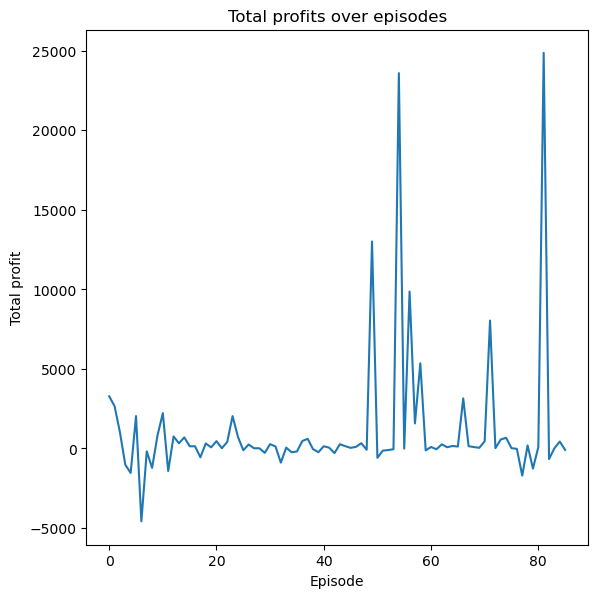

In [178]:
# DEFINE YOUR VISUALIZATION
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,1, figsize=(6, 6),)

#fig.suptitle("Total profits over episodes", fontsize=15)
fig.tight_layout(pad=2)

axs.plot(range(len(t_p)-5), t_p[:-5],)
axs.set_title("Total profits over episodes")
axs.set_xlabel("Episode")
axs.set_ylabel("Total profit")

Text(37.597222222222214, 0.5, 'Total profit')

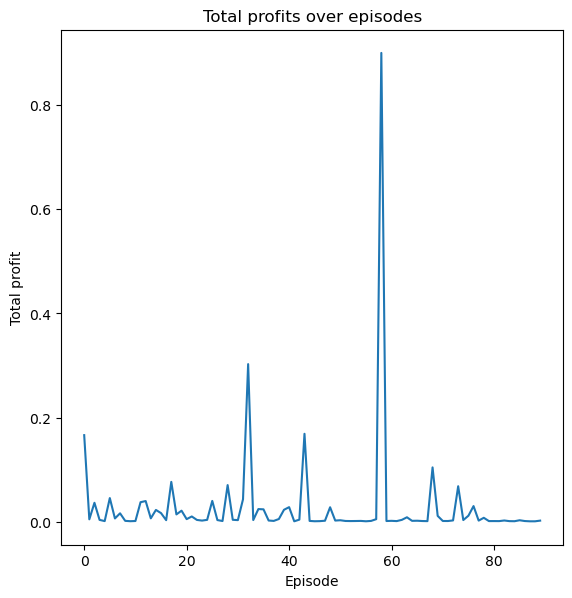

In [190]:
fig, axs = plt.subplots(1,1, figsize=(6, 6),)

#fig.suptitle("Total profits over episodes", fontsize=15)
fig.tight_layout(pad=2)

axs.plot(range(len(llll)), llll,)
axs.set_title("Total profits over episodes")
axs.set_xlabel("Episode")
axs.set_ylabel("Total profit")